In [1]:
from reader import FastqProcessor
import glob
import os
from pathlib import Path
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
barcodes = {"barcode06": "AAGGTTAAGACTACTTTCTGCCTTTGCGAGAACAGCACCT"}
            # "barcode07": "AAGGTTAAAAGGATTCATTCCCACGGTAACACCAGCACCT",
            # "barcode08": "AAGGTTAAACGTAACTTGGTTTGTTCCCTGAACAGCACCT",
            # "barcode09": "AAGGTTAAAACCAAGACTCGCTGTGCCTAGTTCAGCACCT",
            # "barcode10": "AAGGTTAAGAGAGGACAAAGGTTTCAACGCTTCAGCACCT",
            # "barcode11": "AAGGTTAATCCATTCCCTCCGATAGATGAAACCAGCACCT",
            # "barcode12": "AAGGTTAATCCGATTCTGCTTCTTTCTACCTGCAGCACCT",
            # "barcode13": "AAGGTTAAAGAACGACTTCCATACTCGTGTGACAGCACCT",
            # "barcode14": "AAGGTTAAAACGAGTCTCTTGGGACCCATAGACAGCACCT",
            # "barcode15": "AAGGTTAAAGGTCTACCTCGCTAACACCACTGCAGCACCT",
            # "barcode16": "AAGGTTAACGTCAACTGACAGTGGTTCGTACTCAGCACCT"}

In [3]:
artificial_sequences = {
    "Left": "CTTCATGGATCCTGCTCTCG",
    "RCLeft": "CGAGAGCAGGATCCATGAAG",
    "Right": "GGCCCTAAAGCTTAGCACGA",
    "RCRight": "TCGTGCTAAGCTTTAGGGCC",
    # "RCLeft-Left": "CGAGAGCNGGATCCNGCTCTCG",
    # "Right-RCRight": "GGCCCNAAAGCTTTAGGGCC"
}

In [4]:
fastq_dir = "data_samples/new_sequencing_may2025/reads"

In [5]:
overall_statistics = []
overall_distances = []
seq_lengths = []

In [6]:
for barcode, value in barcodes.items():
    filepath = Path(os.path.join(fastq_dir, f"{barcode}.fastq"))
    processor = FastqProcessor(filepath, artificial_sequences | {barcode:value})
    sequence_matches = processor.process_file()
    stats = processor.matches_stats(sequence_matches)
    distances = processor.compute_pairwise_distances(sequence_matches)
    seq_lengths.append({barcode: processor.sequence_lengths})
    overall_statistics.append({barcode: dict(stats)})
    overall_distances.append({barcode: distances})

Processing FASTQ: 100%|██████████| 8355/8355 [00:00<00:00, 81845.76it/s]


In [7]:
# Flatten into a list of records with barcode and value
flattened_lengths = []
for item in seq_lengths:
    for barcode, values in item.items():
        for value in values:
            flattened_lengths.append({'barcode': barcode, 'value': value})

In [8]:
# Create DataFrame
flattened_lengths_df = pd.DataFrame(flattened_lengths)

In [9]:
flattened_lengths_df

,barcode,value
0,barcode06,109
1,barcode06,120
2,barcode06,6
3,barcode06,109
4,barcode06,160
...,...,...
8350,barcode06,400
8351,barcode06,73
8352,barcode06,530
8353,barcode06,42


In [27]:
flattened_lengths_df.to_excel('sequences_lengths.xlsx')

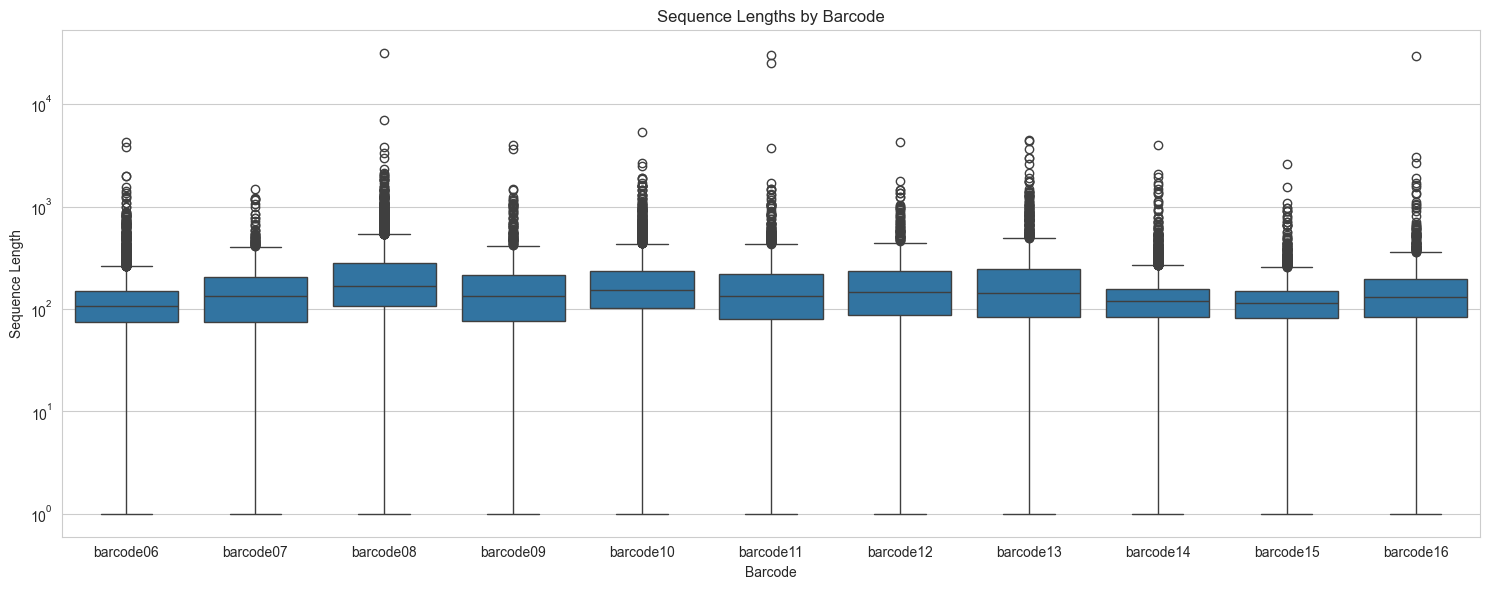

In [10]:
# Create boxplots
plt.figure(figsize=(15, 6))
sns.boxplot(x='barcode', y='value', data=flattened_lengths_df)
plt.yscale('log')
plt.title("Sequence Lengths by Barcode")
plt.xlabel("Barcode")
plt.ylabel("Sequence Length")
plt.tight_layout()
plt.savefig('barcode_lengths.png')
plt.show()

In [10]:
def flatten_stats(data):
    rows = []

    for entry in data:
        for barcode, stats in entry.items():
            n_records = stats.get('number_of_reads', 0)

            for orientation, values in stats.items():
                if orientation == 'number_of_reads':
                    continue
                row = {
                    'barcode': barcode,
                    'orientation': orientation,
                    'count': values['count'],
                    'average_score': values['average_score'],
                    'average_length': values['average_length'],
                    'number_of_reads': n_records
                }
                rows.append(row)

    return pd.DataFrame(rows)

In [11]:
df = flatten_stats(overall_statistics)

In [12]:
df

,barcode,orientation,count,average_score,average_length,number_of_reads
0,barcode06,RCRight,4132,0.954465,18.490077,8355
1,barcode06,RCLeft,4163,0.961782,18.419890,8355
2,barcode06,Right,4787,0.966670,18.811364,8355
3,barcode06,Left,3850,0.963766,18.818442,8355
4,barcode06,barcode06,2043,0.909887,23.463045,8355


In [14]:
df.to_excel('matching_statistics.xlsx')

In [13]:
def flatten_distances(data):
    rows = []
    for barcode_dict in data:
        for barcode, triples in barcode_dict.items():
            for frm, to, dist in triples:
                rows.append({'barcode': barcode, 'from': frm, 'to': to, 'distance': dist})
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

In [14]:
dist_df = flatten_distances(overall_distances)

In [15]:
dist_df.head()

,barcode,from,to,distance
0,barcode06,RCRight,RCLeft,23
1,barcode06,RCLeft,RCRight,23
2,barcode06,RCRight,RCLeft,20
3,barcode06,Right,RCRight,43
4,barcode06,RCRight,RCLeft,19


In [18]:
dist_df.to_excel('distances.xlsx')

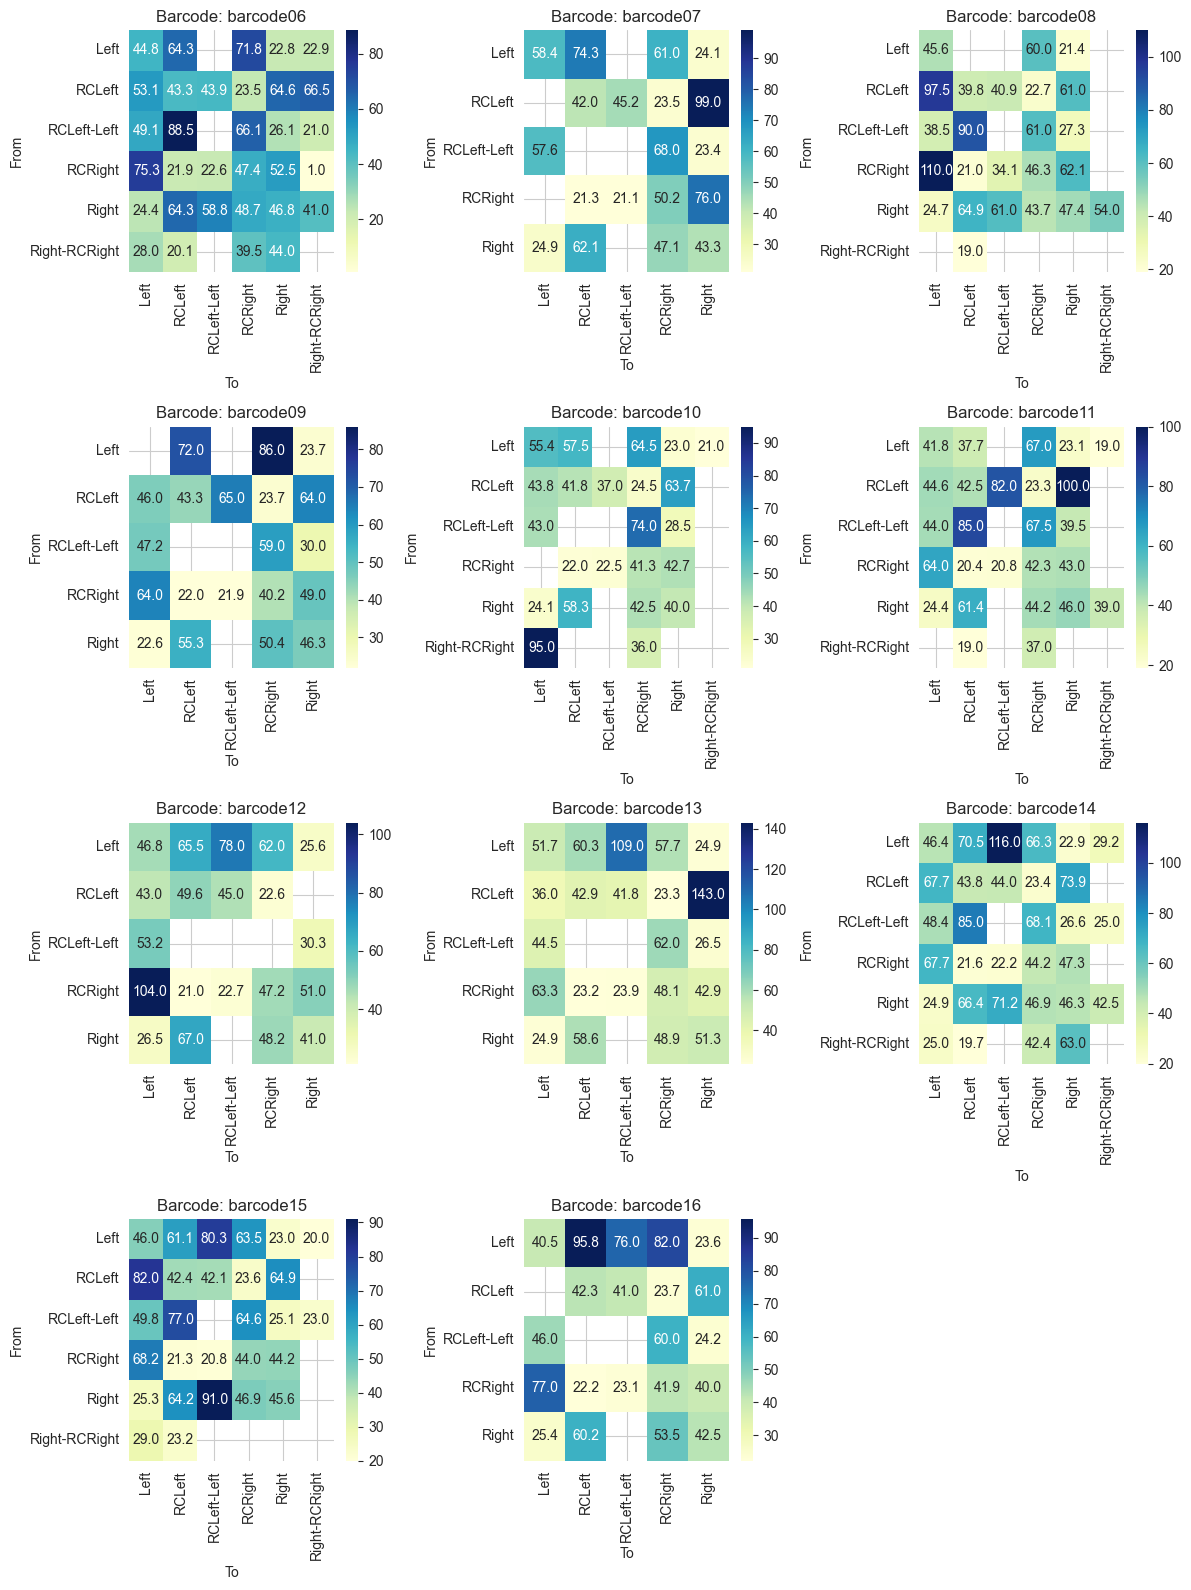

In [19]:
# Create subplots
barcodes = dist_df['barcode'].unique()
# Create 3 rows × 4 columns grid of subplots
n_rows, n_cols = 4, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot heatmaps
for i, barcode in enumerate(barcodes):
    ax = axes[i]
    subset = dist_df[dist_df['barcode'] == barcode]
    pivot = subset.pivot_table(index='from', columns='to', values='distance', aggfunc='mean')
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax)
    ax.set_title(f"Barcode: {barcode}")
    ax.set_xlabel("To")
    ax.set_ylabel("From")

# Hide unused axes if any
for j in range(len(barcodes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("distances.png",dpi=300)
plt.show()

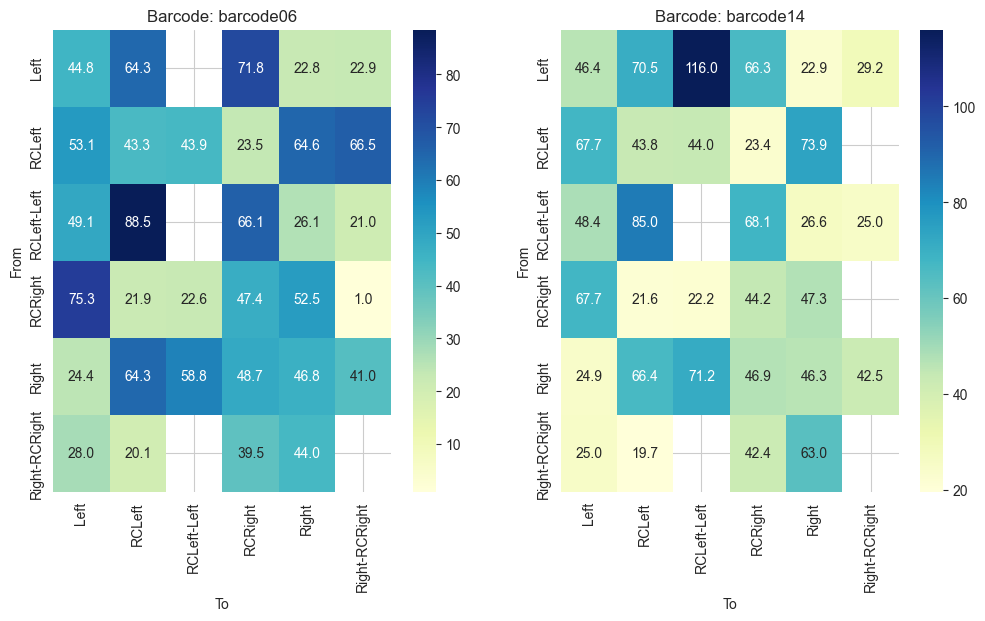

In [20]:
# Filter for barcodes 06 and 14
selected_barcodes = ['barcode06', 'barcode14']
filtered_df = dist_df[dist_df['barcode'].isin(selected_barcodes)]

# Create heatmaps
n_barcodes = len(selected_barcodes)
n_rows = 1
n_cols = n_barcodes

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6))

# Ensure axes is iterable
if n_barcodes == 1:
    axes = [axes]

for i, barcode in enumerate(selected_barcodes):
    ax = axes[i]
    subset = filtered_df[filtered_df['barcode'] == barcode]
    pivot = subset.pivot_table(index='from', columns='to', values='distance', aggfunc='mean')
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax)
    ax.set_title(f"Barcode: {barcode}")
    ax.set_xlabel("To")
    ax.set_ylabel("From")

In [21]:
# Create a combined column for the pair
dist_df['pair'] = dist_df['from'] + ' → ' + dist_df['to']

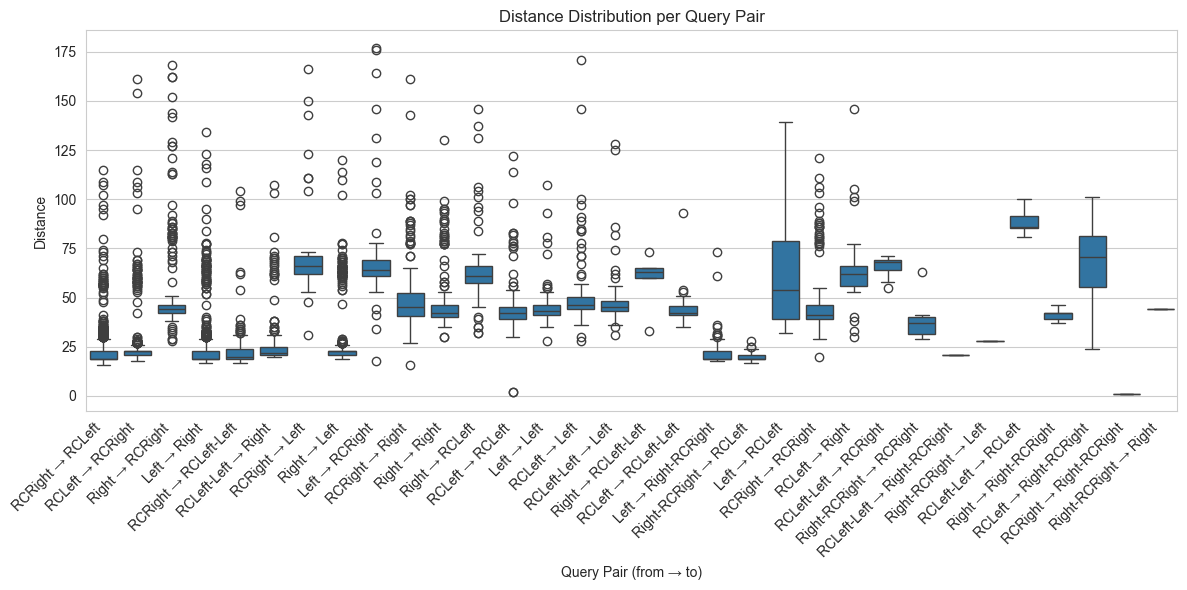

In [22]:
# Create boxplot grouped by the "from → to" pair
plt.figure(figsize=(12, 6))
sns.boxplot(x='pair', y='distance', data=dist_df[dist_df['barcode'] == 'barcode06'])
plt.xticks(rotation=45, ha='right')
plt.title('Distance Distribution per Query Pair')
plt.xlabel('Query Pair (from → to)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [23]:
dist_df

,barcode,from,to,distance,pair
0,barcode06,RCRight,RCLeft,23,RCRight → RCLeft
1,barcode06,RCLeft,RCRight,23,RCLeft → RCRight
2,barcode06,RCRight,RCLeft,23,RCRight → RCLeft
3,barcode06,RCRight,RCLeft,20,RCRight → RCLeft
4,barcode06,Right,RCRight,42,Right → RCRight
...,...,...,...,...,...
31576,barcode16,RCLeft,RCRight,26,RCLeft → RCRight
31577,barcode16,RCRight,RCLeft,23,RCRight → RCLeft
31578,barcode16,RCLeft,RCRight,21,RCLeft → RCRight
31579,barcode16,RCLeft,RCRight,23,RCLeft → RCRight


In [24]:
features = ["RCRight → RCLeft-Left",
            "RCLeft-Left → Right",
            "RCRight → Right",
            "Left → Right-RCRight",
            "Right-RCRight → RCLeft",
            "Left → RCLeft"]

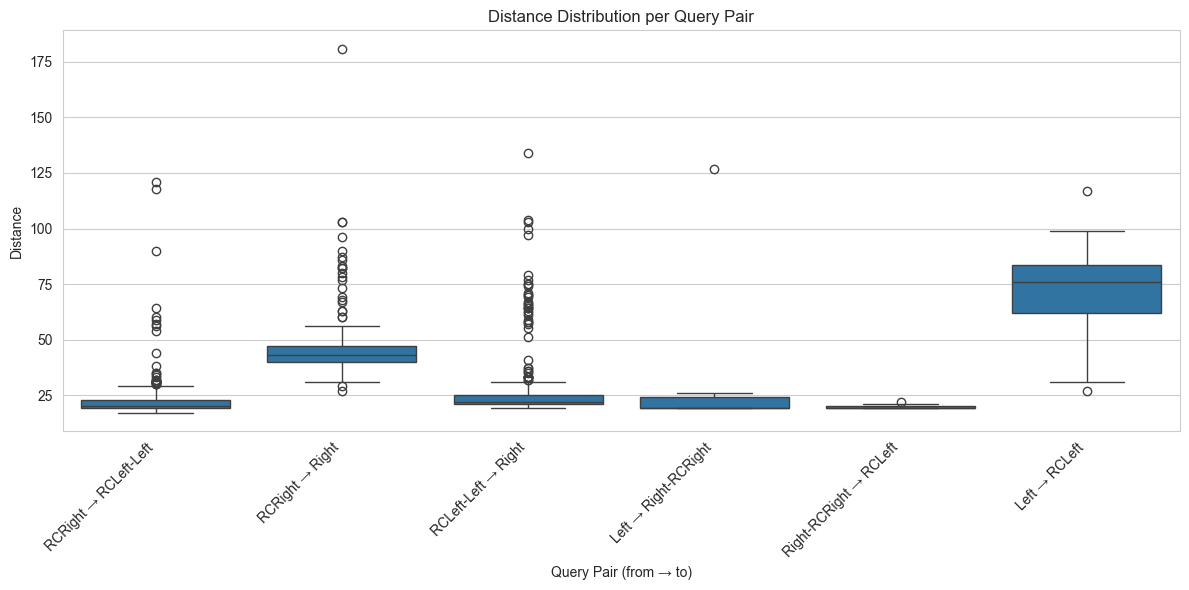

In [26]:
# Create boxplot grouped by the "from → to" pair
plt.figure(figsize=(12, 6))
sns.boxplot(x='pair', y='distance', data=dist_df[(dist_df['barcode'] == 'barcode14') & (dist_df['pair'].isin(features))])
plt.xticks(rotation=45, ha='right')
plt.title('Distance Distribution per Query Pair')
plt.xlabel('Query Pair (from → to)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()